---

# 🏆 **SFPPy Example: Fitting an Arbitrary Combination of Parameters**  
📊 **Estimating** $D[i]$ **and** $k[i]$ **from Experiments Using** `layerLinks` **& Dynamic Simulations**  

---

## 🔬 **Example 4: Sensitivity Analysis & Kinetic Data Fitting**  
---------------------------------------------------------  

### 📜 **Example4.py: Estimation of D and k from Concentration Kinetics in Food Simulants**  

## **🔍 Overview**  
This script illustrates how **📉 diffusivity ($D$) and partition coefficients ($k$)** can be estimated  
from **experimental concentration kinetics** in **🧪 food simulants**.  

The method relies on **🔗 `layerLink` objects**, which allow dynamically adjusting simulation parameters.  

### 🛠 **Workflow:**  
1️⃣ **Define a monolayer material** (**P**) & a **food simulant** (**F**).  
2️⃣ **Enforce a reference partition coefficient** (**$k_F = 1$ for F**) so that **$k_P$ represents the partition coefficient between F & P**.  
3️⃣ **Run a migration simulation** to establish a **baseline**.  
4️⃣ **Generate pseudo-experimental data** 📊 with controlled **noise levels**.  
5️⃣ **Evaluate the squared error** `d2 = R - E` 📉 between **simulation (R) & experiment (E)**.  
6️⃣ **Perform a sensitivity analysis** by varying **$D$ and $k$** to assess their impact.  
7️⃣ **Optimize** **$D$ and $k$** **simultaneously** 🔄 to recover their **original values**.  
8️⃣ **Analyze the goodness of fit** 📏 & evaluate **overfitting risks**.  

---

## 📌 **Key Concepts**  
📌 **`layerLink` for parameter linking** → Modify $D$ and $k$ externally without changing the base layer object.  
📌 **Migration simulation (`F.migration(P)`)** → Computes **mass transfer** from **P → F**.  
📌 **Pseudo-experimental data (`R.pseudoexperiment()`)** → Creates **synthetic datasets** for validation.  
📌 **Fitting (`R.fit(E)`)** → Automatically adjusts **$D$ and $k$** to best match **experimental data**.  

---

## 🎯 **Expected Outcomes**  
✅ **Validation of `layerLink` objects** for parameter optimization.  
✅ **Comparison of simulated vs. experimental data** 📊 to evaluate fit quality.  
✅ **Determination of optimal $D$ and $k$ values** 📏 for given experimental conditions.  

---

## 🔎 **Summary**  
--------------------------------------------------------  
This script demonstrates **an advanced approach** for **parameter estimation in food safety analysis**  
by leveraging **dynamic simulations** and **data fitting techniques**.  

---

📌 **Project:** SFPPy - 🛡️ SafeFoodPackaging Portal in Python Initiative  
👨‍💻 **Author:** INRAE\\olivier.vitrac@agroparistech.fr  
📜 **License:** MIT  

---

### Minimal Setup for SFPPy Core 🚀🔧⚙️

> This setup is designed to work on any machine – whether SFPPy is already installed or not.  

<details>
    <summary>Click to Expand</summary>
  
> The cell attempts to import the core module `patankar.loadpubchem`.  
> - If it **succeeds**, SFPPy is already initialized, and no further action is needed.  
> - If it **fails**, the cell will try to run the initialization script `initialize_sfppy.py` (searched from several candidate paths).  
>   - If the script is found, it will be executed.  
>   - If not, the repository will be cloned (or refreshed) and then initialized.
>  
> After successful initialization, the full path to the SFPPy installation folder is displayed.  
>  
> **Note:** Make sure you are in a directory with access to SFPPy (or that can clone it). In a read-only environment, this cell will help you set up SFPPy temporarily.

</details>

In [3]:
import sys, os
import ipywidgets as widgets
from IPython.display import display, HTML

verbose = True  # Set verbosity flag
clone = True # True enable cloning from GitHub repo

try:
    import patankar.loadpubchem
    if verbose: print("✅ SFPPy is already initialized; skipping initialization.")
except ImportError:
    if verbose: print("⚠️ SFPPy not detected; attempting initialization.")
    base_dirs = ["./SFPPy/utils", "../utils", "./utils", ".", "../../utils", "../../../utils"]
    # Find candidates for the initialization script in various base directories.
    candidates = [os.path.abspath(os.path.join(d, "initialize_sfppy.py"))
                  for d in base_dirs if os.path.exists(os.path.join(d, "initialize_sfppy.py"))]
    if candidates:
        if verbose: print(f"🔍 Running initialization script: {candidates[0]}")
        %run -i {candidates[0]} --no-verbose --no-cd
        try:
            import patankar.loadpubchem
            if verbose: print("✅ SFPPy successfully initialized.")
        except ImportError: print("❌ ERROR: Initialization failed; 'patankar.loadpubchem' is still unavailable.\n", "Current sys.path:\n", sys.path)
    elif clone:
        if not os.path.exists("SFPPy"):
            if verbose: print("📥 SFPPy repository not found. Cloning the repository – please be patient.")
            !git clone https://github.com/ovitrac/SFPPy.git  # First time: clone the repository
        else:
            if verbose: print("🔄 Refreshing the SFPPy repository.")
            !git -C SFPPy pull  # Subsequent times: update the repository if needed
        %cd SFPPy
        installationscript = os.path.abspath(os.path.join(os.getcwd(), "utils", "initialize_sfppy.py"))
        %run -i {installationscript} --no-verbose --no-cd
        try:
            import patankar.loadpubchem
            if verbose:
                print("✅ SFPPy successfully initialized.")
        except ImportError: print("❌ ERROR: Initialization failed; 'patankar.loadpubchem' is still unavailable.\n", "Current sys.path:\n", sys.path)
    else:
        raise FileNotFoundError("❌ ERROR: Either set clone=True or start the notebook from a valid SFPPy installation.\n")

SFPPymainfolder = os.path.abspath(os.path.join(os.path.dirname(patankar.loadpubchem.__file__), ".."))
print("📁 SFPPy installation folder:", SFPPymainfolder)
from utils.nbutils import create_header_footer   # SFPPy utilities for notebooks
(header,footer,separator) = create_header_footer(title="SFPPy - Notebook 📑",what="all"); display(header);

⚠️ SFPPy not detected; attempting initialization.
🔍 Running initialization script: /home/olivi/natacha/python/utils/initialize_sfppy.py
✅ SFPPy successfully initialized.
📁 SFPPy installation folder: /home/olivi/natacha/python


### Dependencies

In [5]:
from patankar.layer import layer, layerLink
from patankar.food import foodlayer
display(separator)

## 1 | **Reference migration problem**

> Migration means desorption from a polymer into a liquid. Three transport properties control mass transfer: diffusivity ($D$), partition coefficient $\frac{k_P}{k_F}$, and the mass transfer resistance $h$.

***

### 1.1 | **Polymer layer:** `P`

In [8]:
P = layer(
    l=(100, "um"),
    D=(1e-10, "cm**2/s"),  # Diffusivity in cm²/s (internally converted to SI)
    C0=1000,  # Initial concentration (arbitrary units)
    k=0.1  # Partition coefficient
)

***

### 1.2 | **Food Layer:** `F`

In [10]:
F = foodlayer(
    contacttime=(10, "days"),
    volume=(1, "L"),
    surfacearea=(6, "dm**2"),
    h=(1e-6, "m/s"),  # Mass transfer coefficient
    CF0=0,  # Initial concentration in the food
    k=1  # Fixed kF, allowing kP to represent kF/P
)

***

### 1.3 | **Create Layer links for the two free paramers:** $D$ and $k_P$
> LayerLinks are sparse objects that store the indices and reference values that need to be changed live. Once the layerLinks are attached to P (with attributes `Dlink`, `klink`, `llink`, `C0link`, `Tlink`), any change in the layerLinks will be reflected in the instance of P.
> 
> LayerLinks objects can be manipulated as lists. For instance, if `D` is a layerLink for diffusivities,  `D[i]` will modify the diffusivity value of the layer indexed $i+1$.
>
> In our publications and in SFPPy, layers are indexed 1,2,3... with 1 being the layer of P in contact with F. Layer 0 in our publications is referred to F. Note that in Python, the indices start at 0.

In [12]:
Dreference, kreference = P.D, P.k  # Store original values for comparison
D = layerLink("D", indices=0, values=Dreference)  # Create link for D
k = layerLink("k", indices=0, values=kreference)  # Create link for k
P.Dlink = D  # Attach links to P
P.klink = k

***

### 1.4 **Reference simulation**

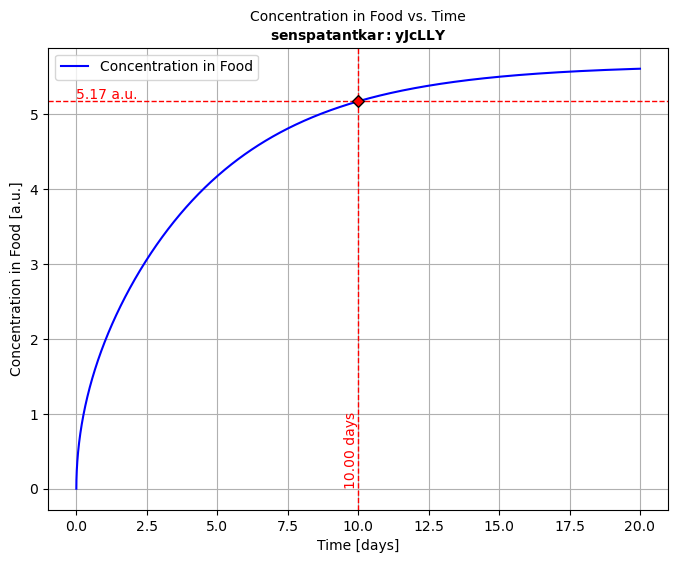

In [14]:
R = F.migration(P)  # Perform mass transfer simulation
R.plotCF()  # Plot the reference concentration profile in food
display(separator)

## 2 | **Create a pseudo experiment**

We create pseudo experiment by sampling `npoints=30` $C_F$ values and by adding a white noise with a standard deviation of 1% (i.e., $95\%$ of values lie within $\pm4\%$ of the simulated value).

***

### 2.1 | **Sampling and adding noise to the reference kinetics**

> This methodology enables us to know the right $D$ and $k$ value

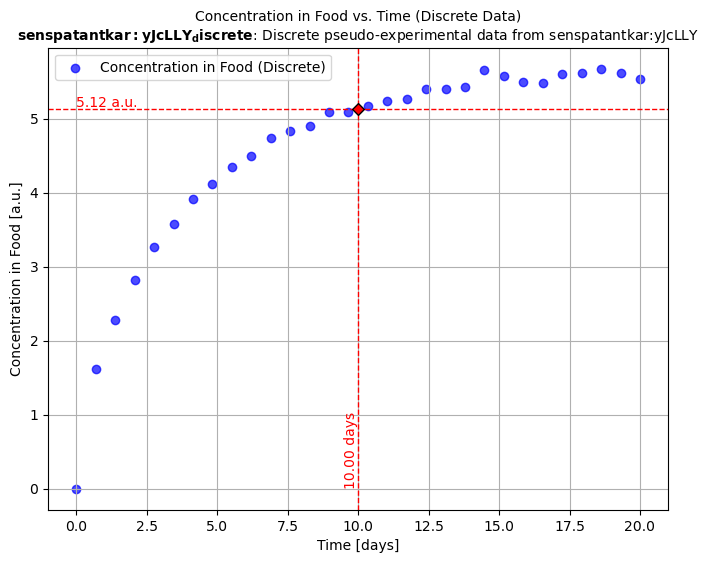

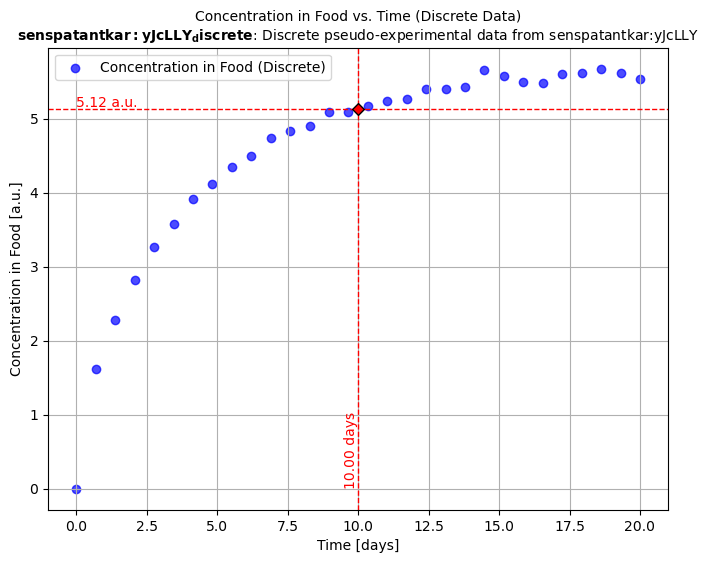

In [18]:
E = R.pseudoexperiment(npoints=30, std_relative=0.01)  # Simulated experimental dataset
E.plotCF()

***

### 2.2 | **We evaluate the original distance to the experimental data**

> This distance represents the minimal distance between the experiment and a model to justify that the model is as good as the experiment.

In [20]:
d2 = R - E  # Compute squared error function
d2_original = d2()  # Evaluate initial deviation from experiment
print(f"Initial squared distance (E-R)**2: {d2_original}")
display(separator)

Initial squared distance (E-R)**2: 1.2746469330362218


## 3 | **Sensitivity Analysis**

### 3.1 | **We change $D$ and $k$ values in $10$ successive steps**

> The effects on the migration kinetics are reported. The distance is several magnitude orders larger than the original distance. The **final values** of $D$ and $k$ will be used as initial guess to recover the **original ones**.

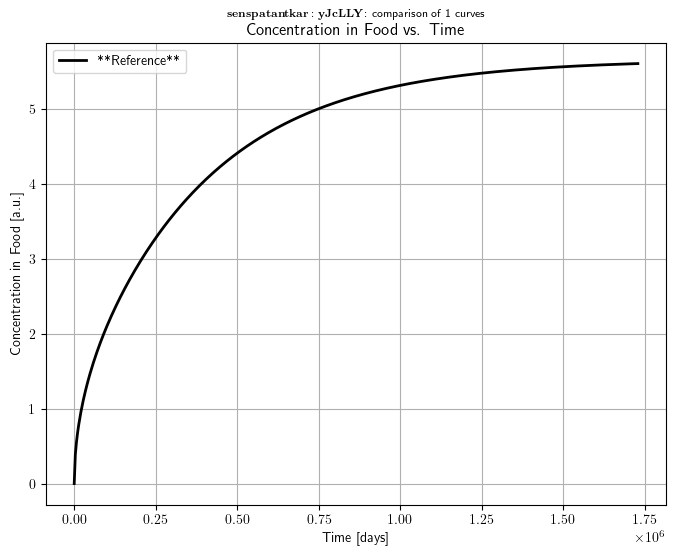

[1/10]: Distance variation = 643.77%
[2/10]: Distance variation = 2576.88%
[3/10]: Distance variation = 6025.13%
[4/10]: Distance variation = 11223.31%
[5/10]: Distance variation = 18410.45%
[6/10]: Distance variation = 27823.89%
[7/10]: Distance variation = 39692.63%
[8/10]: Distance variation = 54230.18%
[9/10]: Distance variation = 71627.45%
[10/10]: Distance variation = 92046.16%


In [23]:
R.comparison.update(0, label="**Reference**", color="black")
R.comparison.plotCF()

# Set iteration count and color mapping
niterations = 10
cmap = R.comparison.jet(niterations)

# Vary D and k systematically
for i in range(1, niterations + 1):
    D[0] = D[0] / 1.1  # Decrease D by 10%
    k[0] = k[0] * 1.1  # Increase k by 10%

    # Format LaTeX labels for D and k
    name = f"{P.Dlatex()[0]}, {P.klatex()[0]}"

    # Rerun simulation with updated parameters
    R.rerun(name=name, color=cmap[i-1])

    # Compute new squared distance
    d2new = d2()
    print(f"[{i}/{niterations}]: Distance variation = {100 * d2new / d2_original - 100:.2f}%")

***
### 3.2 | **We plot the different curves shifting progressively from the reference**

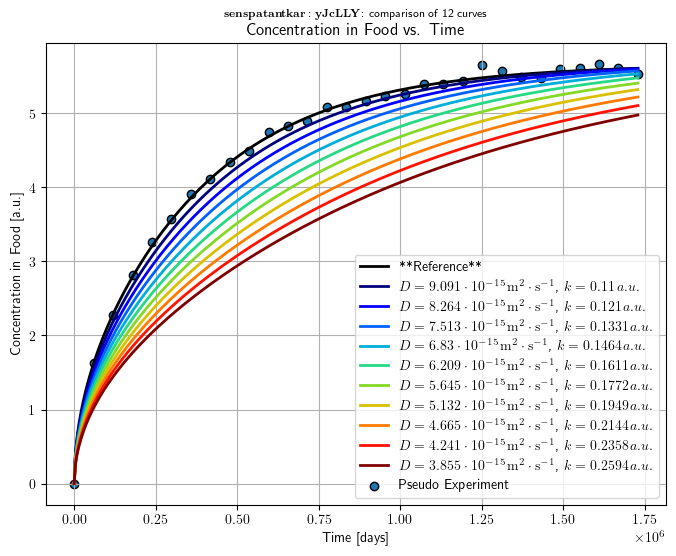

In [25]:
# Add pseudo-experimental data to comparison
R.comparison.add(E, label="Pseudo Experiment", discrete=True)
R.comparison.plotCF()  # Final visualization
display(separator)

# 4. | **Fitting of migration kinetics** 

> Since we are using `layerLink` objects for $D$ and $k$. No parameterization is needed.

***

### 4.1 | **The method** `fit`
> Note that the method `fit` must be started from `R` and not from `E`. Only `R` refers to the model.

In [28]:
d2beforeOptim = d2()  # Distance before fitting
resfit = R.fit(E)  # Perform parameter fitting
d2afterOptim = d2()  # Distance after fitting

Fitting Iteration:
 D=[2.02660678e-14] [m²/s]
 k=[0.24245056] [a.u.]

Fitting Iteration:
 D=[2.02660678e-14] [m²/s]
 k=[0.24245056] [a.u.]

Fitting Iteration:
 D=[8.83937014e-15] [m²/s]
 k=[0.25503568] [a.u.]

Fitting Iteration:
 D=[8.83937014e-15] [m²/s]
 k=[0.25503568] [a.u.]

Fitting Iteration:
 D=[8.83937014e-15] [m²/s]
 k=[0.25503568] [a.u.]

Fitting Iteration:
 D=[8.83937014e-15] [m²/s]
 k=[0.25503568] [a.u.]

Fitting Iteration:
 D=[9.8053893e-15] [m²/s]
 k=[0.24605567] [a.u.]

Fitting Iteration:
 D=[9.8053893e-15] [m²/s]
 k=[0.24605567] [a.u.]

Fitting Iteration:
 D=[9.3098585e-15] [m²/s]
 k=[0.25476694] [a.u.]

Fitting Iteration:
 D=[9.3098585e-15] [m²/s]
 k=[0.23814387] [a.u.]

Fitting Iteration:
 D=[9.3098585e-15] [m²/s]
 k=[0.23814387] [a.u.]

Fitting Iteration:
 D=[9.55441191e-15] [m²/s]
 k=[0.23012227] [a.u.]

Fitting Iteration:
 D=[9.3098585e-15] [m²/s]
 k=[0.22260543] [a.u.]

Fitting Iteration:
 D=[9.67908717e-15] [m²/s]
 k=[0.20443854] [a.u.]

Fitting Iteration:
 D=[9.3

***

### 4.2 | **Print optimization results**

In [30]:
print(f"BEFORE OPTIMIZATION: Distance (E-R)**2 = {d2beforeOptim}")
print(f"AFTER OPTIMIZATION: Distance (E-R)**2 = {d2afterOptim}")
overfitting_flag = "[Overfitting detected]" if d2afterOptim < d2_original else ""
print(f"Variation with original = {100 * d2afterOptim / d2_original - 100:.4g}% {overfitting_flag}\n")
print(f"Fitted D = {D.values} [m²/s] vs. Original D = {Dreference} [m²/s]")
print(f"Fitted k = {k.values} [a.u.] vs. Original k = {kreference} [a.u.]")

BEFORE OPTIMIZATION: Distance (E-R)**2 = 1174.5381664656445
AFTER OPTIMIZATION: Distance (E-R)**2 = 1.2437907443615301
Variation with original = -2.421% [Overfitting detected]

Fitted D = [1.00580445e-14] [m²/s] vs. Original D = [1.e-14] [m²/s]
Fitted k = [0.10001884] [a.u.] vs. Original k = [0.1] [a.u.]


***

### 4.3 | **Plot optimized results**

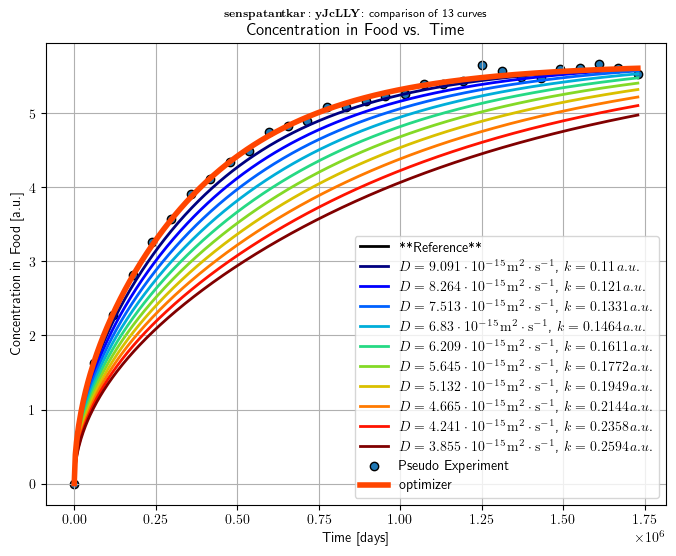

et voilà


In [32]:
R.comparison.plotCF()
print("et voilà"); display(separator,footer)